# perform feature extraction on converted nwb files

In [137]:
from pathlib import Path
import utils

nat_com_nwb_file_df = utils.summary_df(Path('./data/processed/recordings/'), suffix='.nwb')
nat_com_nwb_file_df['file_id'] = nat_com_nwb_file_df.file_name.apply(lambda x: x.rstrip('.nwb'))

In [138]:
nat_com_nwb_file_df

,file_name,path,file_id
0,15o08032.nwb,data/processed/recordings/15o08032.nwb,15o08032
1,2016_03_03_0103.nwb,data/processed/recordings/2016_03_03_0103.nwb,2016_03_03_0103
2,2016_02_29_0065.nwb,data/processed/recordings/2016_02_29_0065.nwb,2016_02_29_0065
3,19320017.nwb,data/processed/recordings/19320017.nwb,19320017
4,19320001.nwb,data/processed/recordings/19320001.nwb,19320001
...,...,...,...
111,19320024.nwb,data/processed/recordings/19320024.nwb,19320024
112,19129047.nwb,data/processed/recordings/19129047.nwb,19129047
113,2016_03_01_0000.nwb,data/processed/recordings/2016_03_01_0000.nwb,2016_03_01_0000
114,15o08002.nwb,data/processed/recordings/15o08002.nwb,15o08002


In [139]:
# Load IPFX libraries
from ipfx.dataset.create import create_ephys_data_set
from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps
from ipfx.qc_feature_extractor import sweep_qc_features
from ipfx.stimulus import StimulusOntology
from ipfx.data_set_features import extract_cell_long_square_features

from ipfx.feature_extractor import SpikeFeatureExtractor, SpikeTrainFeatureExtractor
import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch

#Load Plotting 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# these are basic IPFX objects for working with sweeps and sets of sweeps
from ipfx.sweep import Sweep, SweepSet 

# Load pandas library too
import pandas as pd
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps

#Load json
import json
import allensdk.core.json_utilities as ju

In [140]:
def summarize_ls_ephys_features(lsa_results):
    hero_keep_features = ['adapt', 'avg_rate', 'first_isi', 'isi_cv', 'latency', 'mean_isi', 'median_isi', 
                          'stim_amp']
    rheo_keep_features = ['threshold_v', 'peak_v', 'trough_v', 
     'fast_trough_v', 'adp_v', 'width', 'upstroke_downstroke_ratio', 'peak_t', 'fast_trough_t', 'trough_t']
    
    overall_cell_keep_features = ['v_baseline', 'rheobase_i', 'fi_fit_slope', 
                                  'sag', 'vm_for_sag', 'input_resistance', 'tau']
    
    hero_small_dict = lsa_results['hero_sweep'][hero_keep_features]
    rheobase_sweep_index = lsa_results['rheobase_sweep'].name
    rheobase_sweep = lsa_results['spikes_set'][rheobase_sweep_index].iloc[0]
    
    rheo_spike_small_dict = rheobase_sweep[rheo_keep_features]
    rheo_first_isi = lsa_results['rheobase_sweep']['first_isi']
    rheo_spike_small_dict['rheo_first_isi'] = rheo_first_isi

    spike_comb_dict = {**hero_small_dict, **rheo_spike_small_dict}

    overall_cell_features = {x: lsa_results[x] for x in overall_cell_keep_features if x in lsa_results}
    final_cell_feature_dict = {**spike_comb_dict, **overall_cell_features}
    return(final_cell_feature_dict)

# Read in metadata from Shreejoy's github repo

In [141]:
# Read in metadata from Shreejoy's github repo

# read final csv that has the ouput of metadata gathering process
nat_com_meta_url = 'https://raw.githubusercontent.com/stripathy/valiante_lab_abf_process/master/output_files/cell_final_raw_meta_df.csv'
nat_com_meta = pd.read_csv(nat_com_meta_url)
nat_com_meta['file_id'] = nat_com_meta.cell_id.apply(lambda x: x.rstrip('.abf'))

In [142]:
nat_com_meta.tail()

,Unnamed: 0,cell_id,expt_date,layer_name,cell_type,recorder_name,full_path,abf_tag,abf_version,file_time,...,stim_chan,stim_duration,stim_end_time,stim_gain,stim_name,stim_path,stim_sampling_rate,stim_start_time,valid_stim,file_id
207,207,2020_01_27_0042.abf,2020-01-27,L5,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,"C7 , L5 ,RMP -60.7 mv",2.6.0.0,2020-01-27 20:55:03.437,...,1,0.6,0.69205,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,20000,0.0921,True,2020_01_27_0042
208,210,2020_01_28_0029.abf,2020-01-28,L5,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,NaN,2.6.0.0,2020-01-28 20:59:37.984,...,1,0.6,0.69205,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,20000,0.0921,True,2020_01_28_0029
209,208,2020_01_28_0008.abf,2020-01-28,L5,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,NaN,2.6.0.0,2020-01-28 17:23:29.906,...,1,0.6,0.69205,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,20000,0.0921,True,2020_01_28_0008
210,209,2020_01_28_0017.abf,2020-01-28,L5,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,"C4, L5, RMP -56.3 mV",2.6.0.0,2020-01-28 18:31:27.390,...,1,0.6,0.69205,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,20000,0.0921,True,2020_01_28_0017
211,211,2020_03_02_0023.abf,2020-03-02,L5,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,"C3-, RMp -68, 93, L5",2.6.0.0,2020-03-02 16:36:35.609,...,1,0.6,0.67435,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,20000,0.0744,True,2020_03_02_0023


In [143]:
# put extracted features somewhere
features_output_path = Path('./data/processed/features')
features_output_path.mkdir(exist_ok=True)

In [144]:
nat_com_nwb_file_df = nat_com_nwb_file_df.merge(nat_com_meta, left_on='file_id', right_on='file_id')

In [145]:
nat_com_nwb_file_df

,file_name,path,file_id,Unnamed: 0,cell_id,expt_date,layer_name,cell_type,recorder_name,full_path,...,stim_amp_vec,stim_chan,stim_duration,stim_end_time,stim_gain,stim_name,stim_path,stim_sampling_rate,stim_start_time,valid_stim
0,15o08032.nwb,data/processed/recordings/15o08032.nwb,15o08032,122,15o08032.abf,2015-10-08,L5,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-400. -350. -300. ... 450. 500. 550.],1,1.224115,1.632663,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,9803,0.40865,True
1,2016_03_03_0103.nwb,data/processed/recordings/2016_03_03_0103.nwb,2016_03_03_0103,155,2016_03_03_0103.abf,2016-03-03,L2.3,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-400. -350. -300. ... 650. 700. 750.],1,0.720029,0.960338,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,16666,0.24037,True
2,2016_02_29_0065.nwb,data/processed/recordings/2016_02_29_0065.nwb,2016_02_29_0065,149,2016_02_29_0065.abf,2016-02-29,L5,Int,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-400. -350. -300. ... 400. 450. 500.],1,0.720029,0.960338,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,16666,0.24037,True
3,19320017.nwb,data/processed/recordings/19320017.nwb,19320017,180,19320017.abf,2019-03-20,L2.3,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-400. -350. -300. ... 301. 350. 400.],3,0.346100,0.780500,0.2,sweepY,/Users/stripathy/Downloads/homeira_new_intrins...,10000,0.18060,True
4,19320001.nwb,data/processed/recordings/19320001.nwb,19320001,183,19320001.abf,2019-03-20,L5,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-401. -351. -300. ... 299. 350. 400.],3,0.334700,0.780400,0.2,sweepY,/Users/stripathy/Downloads/homeira_new_intrins...,10000,0.18070,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,19320024.nwb,data/processed/recordings/19320024.nwb,19320024,179,19320024.abf,2019-03-20,L3c,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-400. -349. -301. ... 300. 351. 401.],3,0.228200,0.780500,0.2,sweepY,/Users/stripathy/Downloads/homeira_new_intrins...,10000,0.18060,True
112,19129047.nwb,data/processed/recordings/19129047.nwb,19129047,167,19129047.abf,2019-01-29,L3c,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-400. -350. -299. ... 300. 350. 401.],3,0.131300,0.780100,0.2,sweepY,/Users/stripathy/Downloads/homeira_new_intrins...,10000,0.18190,True
113,2016_03_01_0000.nwb,data/processed/recordings/2016_03_01_0000.nwb,2016_03_01_0000,150,2016_03_01_0000.abf,2016-03-01,L2.3,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-400. -350. -300. ... 700. 750. 800.],1,0.720029,0.960338,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,16666,0.24037,True
114,15o08002.nwb,data/processed/recordings/15o08002.nwb,15o08002,116,15o08002.abf,2015-10-08,L5,Pyr,Homeira,/Users/stripathy/Downloads/homeira_new_intrins...,...,[-400. -350. -300. ... 450. 500. 550.],1,1.224115,1.632663,1.0,sweepC,/Users/stripathy/Downloads/homeira_new_intrins...,9803,0.40865,True


In [146]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

In [147]:
from ipfx.error import FeatureError

# perform feature extraction on set of nwb files

In [169]:
data_dict = {}
for i, row in nat_com_nwb_file_df.iterrows():
    print(f'{row.file_name}')
    try:
        data_set = create_ephys_data_set(nwb_file=row.path, ontology=ontology_path)
        cell_features, sweep_features, cell_record, sweep_records, _, _ = extract_data_set_features(data_set)
        long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names)
        long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
        long_square_sweeps = data_set.sweep_set()

        # Select epoch corresponding to the actual recording from the sweeps
        # and align sweeps so that the experiment would start at the same time
        long_square_sweeps.select_epoch("recording")

        # find the start and end time of the stimulus
        # (treating the first sweep as representative)
        stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0], test_pulse=False)
        stim_start_time = long_square_sweeps.t[0][stim_start_index]
        stim_end_time = long_square_sweeps.t[0][stim_end_index]

        stim_start_time = row.stim_start_time
        stim_end_time = row.stim_end_time

        # build the extractors
        spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
        sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval = .05)

        # run the analysis and print out a few of the features
        long_square_analysis = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-500.0)
        data = long_square_analysis.analyze(long_square_sweeps)    

        specimen_dict = summarize_ls_ephys_features(data)
        #data_dict[curr_file] = specimen_dict
        data_dict[row.file_name] = specimen_dict
        
    except (AssertionError, AttributeError, TypeError, FeatureError) as e:
    #except FeatureError as e:
        print(f'Error: {e} \n') # {row.filename} \n')

15o08032.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_03_03_0103.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_02_29_0065.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

19320017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320001.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

19128036.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_03_03_0100.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

20140127_600_1_0118.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

2020_03_02_0023.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

2016_02_04_0042.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

13d03029.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

13d03005.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

2016_02_25_0005.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

2016_01_28_0004.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

20131211_600_1_0067.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

15o08020.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

20131211_600_1_0066.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

19129072.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

19129064.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

19320007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_02_04_0045.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

15o08022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_01_28_0012.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_02_25_0007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

13d03007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

2016_03_01_0047.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2020_01_06_0082.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


20131211_600_1_0002.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

2020_01_27_0002.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

2015_11_09_0053.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

19122022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2020_01_06_0108.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that p

2015_11_09_0085.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

19129015.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

2020_01_28_0008.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

2020_01_06_0095.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2015_11_09_0078.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_02_04_0009.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

2016_02_04_0021.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

13d02022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

19128068.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_03_03_0002.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

20131211_600_1_0160.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

19129004.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2020_01_06_0090.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

19128044.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


Error: Cannot fit f-I curve slope with less than two sweeps 

2020_01_27_0038.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

2019_11_26_0094.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

19122024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

2016_02_04_0018.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

13n05011.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

2016_02_25_0073.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

2019_09_03_0088.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  


Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 

19122026.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

2016_02_04_0033.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

13n21007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

19129037.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2019_11_26_0110.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

2016_02_25_0082.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2020_01_06_0048.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2015_11_09_0106.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2019_11_28_0079.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_11_28_0119.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


20140127_600_1_0158.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

19122017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19122003.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_02_29_0032.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2020_01_06_0101.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

2016_02_25_0134.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2015_11_09_0107.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2019_11_28_0093.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320041.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

2020_01_28_0017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

19129022.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


13d03040.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

2020_01_28_0029.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2020_01_06_0063.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

2016_02_04_0015.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_02_04_0029.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2020_01_27_0008.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

19128061.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_02_25_0255.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

2019_09_03_0045.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  


Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 

2019_11_04_0113.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


13d02004.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

20131211_600_1_0184.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

20131211_600_1_0190.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

19129040.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

20131211_600_1_0108.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

2020_01_06_0017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


15o08007.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

19129069.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
INFO:root:Need to recalculate threshold-peak pair th

19129057.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

15o08038.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

13d02049.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

19128003.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


20131211_600_1_0081.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

2020_01_27_0042.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:Assigned subthreshold minimum amplitude of -100.000000.
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_lev

20131211_600_1_0042.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

15o08011.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2016_03_03_0054.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

13d03008.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

Error: No spiking long square sweeps, cannot compute cell features. 

19129052.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320025.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_09_03_0036.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  


Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 

2016_01_28_0019.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

2015_11_09_0017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2015_11_09_0003.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19320030.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2019_09_03_0023.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  


Error: <class 'tuple'> is not a stimulus or response PatchClampSeries 

19320024.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


19129047.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  


2016_03_01_0000.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

15o08002.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

15o08017.nwb


INFO:root:  
INFO:root:***** ***** ***** Analyzing cell features: ***** ***** *****
INFO:root:------------------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Long Squares: ***** ***** *****
INFO:root:-------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
INFO:root:  
INFO:root:***** ***** ***** Short Squares: ***** ***** *****
INFO:root:--------------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Ramps: ***** ***** *****
INFO:root:------------------------------------------
INFO:root:  
INFO:root:  
INFO:root:***** ***** ***** Analyzing sweep features: ***** ***** *****
INFO:root:-------------------------------------------------------------
INFO:root:  
/Users/stripathy/anaconda3/envs/nwbephys/lib/python3

In [150]:
dt_df = pd.DataFrame(data_dict)
nat_com_longsquare_df = dt_df.T

In [151]:
nat_com_longsquare_df

,adapt,avg_rate,first_isi,isi_cv,latency,mean_isi,median_isi,stim_amp,threshold_v,peak_v,...,fast_trough_t,trough_t,rheo_first_isi,v_baseline,rheobase_i,fi_fit_slope,sag,vm_for_sag,input_resistance,tau
15o08032.nwb,0.025671,12.254771,0.045904,0.185785,0.024992,0.078591,0.085178,150.000000,-46.544189,51.179199,...,0.476385,0.517801,0.063552,-59.161621,100.000000,0.024064,0.080064,-80.827637,51.609583,0.012116
2016_03_03_0103.nwb,0.158713,11.111593,0.013561,0.468069,0.073623,0.084861,0.103924,249.999985,-37.310596,50.152786,...,0.392656,0.393016,0.015541,-65.452421,200.000000,0.037880,0.097288,-84.393112,43.874104,0.017017
2016_02_29_0065.nwb,-0.002228,29.167931,0.040622,0.090739,0.023041,0.032983,0.033031,100.000000,-39.903942,38.625420,...,0.300432,0.301692,0.072363,-63.777348,50.000000,0.175765,0.167399,-98.093346,213.170767,0.028196
19320017.nwb,0.232653,6.667778,0.061800,0.372042,0.063800,0.107767,0.102000,150.024414,-33.044117,41.464554,...,0.566500,0.647600,NaN,-73.134571,99.487305,0.059596,0.025747,-98.031296,94.525866,0.012607
19320001.nwb,0.307538,8.337502,0.018900,0.531679,0.052800,0.100975,0.115450,148.803711,-39.222244,53.749565,...,0.298800,0.299000,0.030500,-64.493661,99.975586,0.066464,0.109240,-101.981644,84.223703,0.015239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19320024.nwb,NaN,3.333889,0.077100,0.000000,0.051200,0.077100,0.077100,199.951172,-39.413799,49.880638,...,0.488800,0.540600,NaN,-76.193106,149.902344,0.028565,0.066192,-98.602646,75.450905,0.010458
19129047.nwb,0.086530,13.373454,0.030200,0.294825,0.028100,0.067171,0.072000,249.755859,-41.258205,54.719585,...,0.237400,0.237800,0.052100,-66.979090,199.707031,0.060016,0.089398,-94.480865,65.147266,0.009334
2016_03_01_0000.nwb,0.145762,8.333694,0.043022,0.374860,0.036241,0.101152,0.110884,350.000000,-44.517334,58.473389,...,0.310692,0.343574,0.072723,-61.950842,300.000000,0.038386,0.111151,-71.842773,24.020238,0.008042
15o08002.nwb,0.082053,6.535878,0.058145,0.299605,0.048149,0.161088,0.164847,150.000000,-45.566212,46.224560,...,0.520657,0.682750,0.760583,-63.438057,100.000000,0.046939,0.294718,-88.992722,60.462601,0.018802


# compare extracted features from nwb file with features extracted from same files stored as abfs

In [170]:
import pandas as pd
nab_com_abf_features = pd.read_csv('https://raw.githubusercontent.com/stripathy/valiante_lab_abf_process/master/output_files/extracted_cell_features.csv')
nab_com_abf_features['file_id'] = nab_com_abf_features.cell_id.apply(lambda x: x.rstrip('.abf'))

In [171]:
nab_com_abf_features

,Unnamed: 0,adapt,adp_v,avg_rate,cell_id,fast_trough_t,fast_trough_v,fi_fit_slope,first_isi,input_resistance,...,stim_amp,tau,threshold_v,trough_t,trough_v,upstroke_downstroke_ratio,v_baseline,vm_for_sag,width,file_id
0,0,0.126702,NaN,10.001667,13n05011.abf,0.23190,-42.211914,0.095254,0.04990,96.984862,...,100.000001,0.022872,-36.022949,0.26250,-45.861816,1.774152,-53.328296,-94.458008,0.00130,13n05011
1,1,0.013467,-44.799805,26.671112,13n21007.abf,0.14620,-49.575806,0.063820,0.02900,156.707761,...,100.000001,0.011570,-43.212891,0.15820,-51.956177,1.292964,-56.415777,-102.859497,0.00140,13n21007
2,2,0.047345,-46.844482,21.670278,13d02004.abf,0.17990,-50.140381,0.133356,0.02060,115.124510,...,100.000001,0.020581,-52.404785,0.20900,-52.380371,1.528298,-57.059026,-101.141357,0.00120,13d02004
3,3,NaN,NaN,3.333889,13d02022.abf,0.17450,-56.439209,0.030005,0.13660,89.819335,...,200.000003,0.014647,-49.554443,0.17440,-56.597900,1.331957,-61.346358,-98.571777,0.00110,13d02022
4,4,0.022092,-53.253174,21.670278,13d02049.abf,0.17980,-54.675293,0.111447,0.03350,128.283689,...,100.000001,0.021952,-52.264404,0.20100,-56.396484,1.483517,-59.401261,-101.770020,0.00100,13d02049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,205,0.261627,NaN,8.334028,2020_01_27_0042.abf,0.36785,-39.062500,-0.004038,0.02595,108.796313,...,110.000000,0.027586,-41.534424,0.36825,-39.154053,2.970829,-62.980569,-93.048096,0.00245,2020_01_27_0042
206,206,0.080401,NaN,11.667639,2020_01_28_0029.abf,0.15285,-49.346924,0.097151,0.04335,79.528809,...,200.000000,0.016257,-44.708252,0.18465,-52.886963,1.763848,-67.546178,-96.405029,0.00110,2020_01_28_0029
207,207,0.058845,NaN,11.667639,2020_01_28_0008.abf,0.15325,-49.743652,0.104771,0.06065,68.725586,...,200.000000,0.015406,-41.503906,0.18080,-52.062988,1.311535,-63.138303,-91.308594,0.00100,2020_01_28_0008
208,208,0.050613,NaN,18.334861,2020_01_28_0017.abf,0.13910,-38.482666,0.102389,0.02470,156.616211,...,150.000000,0.017728,-30.334473,0.14065,-38.726807,1.472168,-54.991890,-102.264404,0.00145,2020_01_28_0017


# merge nwb and abf based feature data frames

In [173]:
nat_com_longsquare_df
nat_com_longsquare_df['file_id'] = nat_com_longsquare_df.index.to_series().apply(lambda x: x.rstrip('.nwb'))
nat_com_longsquare_df_merged = nat_com_longsquare_df.merge(nab_com_abf_features, 
                                                           left_on = "file_id", 
                                                           right_on = "file_id", 
                                                           suffixes=('_nwb', '_abf'))

In [174]:
nat_com_longsquare_df_merged

,adapt_nwb,avg_rate_nwb,first_isi_nwb,isi_cv_nwb,latency_nwb,mean_isi_nwb,median_isi_nwb,stim_amp_nwb,threshold_v_nwb,peak_v_nwb,...,sag_abf,stim_amp_abf,tau_abf,threshold_v_abf,trough_t_abf,trough_v_abf,upstroke_downstroke_ratio_abf,v_baseline_abf,vm_for_sag_abf,width_abf
0,0.025671,12.254771,0.045904,0.185785,0.024992,0.078591,0.085178,150.000000,-46.544189,51.179199,...,0.080064,150.0,0.013902,-46.544189,0.517801,-43.657227,3.024848,-59.161621,-80.827637,0.002040
1,0.158713,11.111593,0.013561,0.468069,0.073623,0.084861,0.103924,249.999985,-37.310596,50.152786,...,0.097288,250.0,0.018730,-37.310596,0.393016,-40.246387,2.199085,-65.452421,-84.393112,0.001560
2,-0.002228,29.167931,0.040622,0.090739,0.023041,0.032983,0.033031,100.000000,-39.903942,38.625420,...,0.167398,100.0,0.034097,-39.903942,0.301692,-63.692394,1.203754,-63.777348,-98.093338,0.001140
3,0.232653,6.667778,0.061800,0.372042,0.063800,0.107767,0.102000,150.024414,-33.044117,41.464554,...,0.025747,150.0,0.015799,-33.044117,0.647600,-50.378101,2.093111,-73.134571,-98.031296,0.002800
4,0.307538,8.337502,0.018900,0.531679,0.052800,0.100975,0.115450,148.803711,-39.222244,53.749565,...,0.109240,150.0,0.018170,-39.222240,0.299000,-39.756298,3.165766,-64.493661,-101.981644,0.002500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NaN,3.333889,0.077100,0.000000,0.051200,0.077100,0.077100,199.951172,-39.413799,49.880638,...,0.066191,200.0,0.012515,-39.413795,0.540600,-49.927101,2.679481,-76.193096,-98.602638,0.002800
86,0.086530,13.373454,0.030200,0.294825,0.028100,0.067171,0.072000,249.755859,-41.258205,54.719585,...,0.089398,250.0,0.010644,-41.258202,0.237800,-44.950829,2.609857,-66.979086,-94.480858,0.002300
87,0.145762,8.333694,0.043022,0.374860,0.036241,0.101152,0.110884,350.000000,-44.517334,58.473389,...,0.111151,350.0,0.008819,-44.517334,0.343574,-44.883545,3.177398,-61.950841,-71.842773,0.002160
88,0.082053,6.535878,0.058145,0.299605,0.048149,0.161088,0.164847,150.000000,-45.566212,46.224560,...,0.294718,150.0,0.021679,-45.566212,0.682750,-53.506886,2.749153,-63.438057,-88.992722,0.001734


In [175]:
nat_com_longsquare_df_merged[["file_id", 'width_nwb', 'width_abf']]

,file_id,width_nwb,width_abf
0,15o08032,0.002040,0.002040
1,2016_03_03_0103,0.001560,0.001560
2,2016_02_29_0065,0.001140,0.001140
3,19320017,0.002800,0.002800
4,19320001,0.002500,0.002500
...,...,...,...
85,19320024,0.002800,0.002800
86,19129047,0.002300,0.002300
87,2016_03_01_0000,0.002160,0.002160
88,15o08002,0.001734,0.001734


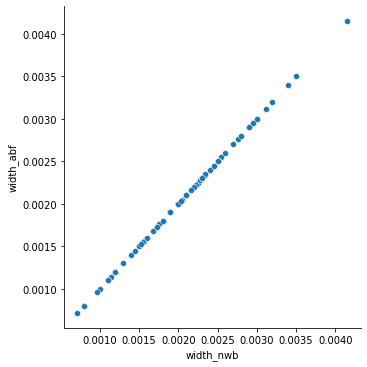

In [176]:
import seaborn as sns

g = sns.relplot(
    data=nat_com_longsquare_df_merged,
    x="width_nwb", y="width_abf",
)

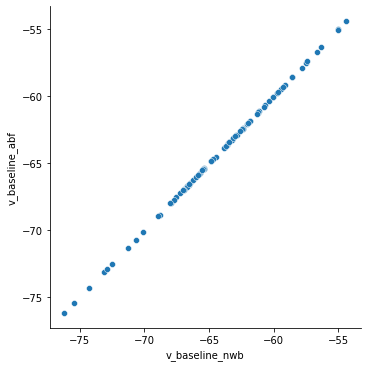

In [177]:
import seaborn as sns

g = sns.relplot(
    data=nat_com_longsquare_df_merged,
    x="v_baseline_nwb", y="v_baseline_abf",
)

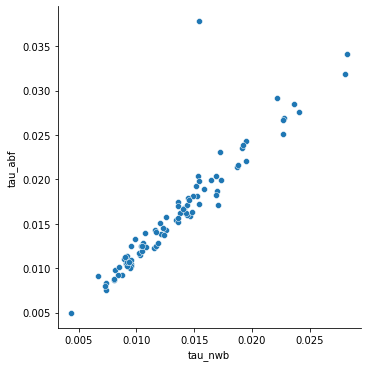

In [178]:
import seaborn as sns

g = sns.relplot(
    data=nat_com_longsquare_df_merged,
    x="tau_nwb", y="tau_abf",
)